# “All Press is Good Press?” : Analysis on the Relation Between Subreddit Reviews and Steam Player Counts

#### Team Members: James Clark (JAC692), Alexander Hertadi (AFH78), Katherine O’Conner (KSO25)

### Introduction and Problem Statement:

There is a famous saying “all press is good press”. Is this actually true? The aim of our project is to analyze the association between the sentiment and count of subreddit reviews of a few specific video games and their Steam player counts. We will attempt to measure video game sales via proxy through Steam player counts. There are two overarching goals:

- We want to explore how the play-style design of the game (single-release, single release and DLC content, single-release and updates) correlates to reddit traffic and steam player counts of the games over time. 
- We want to explore how negative vs. positive subreddit reviews correlate with Steam player count

With these goals in mind, we chose three games that each represented the play-style designs described above. We also opted for games released in 2016 as the Reddit torrent data is much smaller and more feasible to work with from that time frame. Also, since these games were released so long ago, we are better able to capture play trends and internet traffic patterns of the games over their most relevant timelines. We chose Dark Souls III, No Man’s Sky, and Stardew Valley. From our own background knowledge, No Man’s Sky is infamous for its negative review upon release, yet was still wildly popular.

### Hypothesis:

We expect to find that single release video games will have an initial surge in sales/player count and taper off with time, whereas video games that get patches or additional downloadable content will experience more stable sales/player count. We expect this same trend for the count of subreddit reviews. We expect no strong relationship between time of release and sentiment of reviews. 

Generally, we expect the number of Reddit reviews to be the most important predictor of Steam player counts. However, we predict that more positive sentiment reviews will be associated with more stable Steam player counts, whereas more negative sentiment reviews will be associated with sporadic steam player counts and an initial spike upon release. 



### Import Statements

In [34]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [35]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jamesclark/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Load Output Data (Steam Player Counts)

In [36]:
darksouls3_y = pd.read_csv("Daily Dark Souls Player Count.csv").fillna(0)
no_mans_sky_y = pd.read_csv("Daily No Mans Sky Player Count.csv").fillna(0)
stardewvalley_y = pd.read_csv("Daily Stardew Player Count.csv").fillna(0)

In [37]:
darksouls3_y["DateTime"] = pd.to_datetime(pd.to_datetime(darksouls3_y["DateTime"]).dt.date)
no_mans_sky_y["DateTime"] = pd.to_datetime(pd.to_datetime(no_mans_sky_y["DateTime"]).dt.date)
stardewvalley_y["DateTime"] = pd.to_datetime(pd.to_datetime(stardewvalley_y["DateTime"]).dt.date)

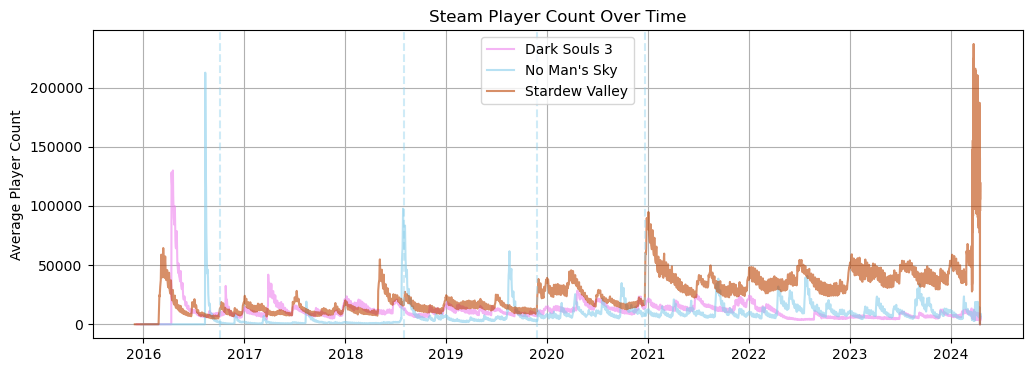

In [38]:
stardew_updates = pd.read_csv("Stardew Updates.csv")
stardew_updates["Date"] = pd.to_datetime(stardew_updates["Date"])

plt.figure(figsize=(12, 4))
games = [darksouls3_y, no_mans_sky_y, stardewvalley_y]
colors = ["violet", "skyblue", "#bd4404"]
for i in range(3):
    game = games[i]
    plt.plot(game["DateTime"], game["Players"], color = colors[i], alpha=0.6)

for i in range(len(stardew_updates)):
    plt.axvline(x = stardew_updates["Date"][i], linestyle="--", color="skyblue", alpha=0.4)

plt.grid()
plt.title("Steam Player Count Over Time")
plt.ylabel("Average Player Count")
plt.legend(labels=["Dark Souls 3", "No Man's Sky", "Stardew Valley"])
plt.show()

### Load Input Data (Subreddit Posts)

In [39]:
posts = pd.read_json('filtered_post_combined.jsonl', lines=True)

posts["created_utc"] = pd.to_datetime(posts["created_utc"], unit='s')
posts = posts.loc[posts['selftext'] != '[removed]']
posts = posts.loc[posts['selftext'] != '[deleted]']
posts = posts.loc[posts['selftext'] != '']
posts = posts.reset_index()

In [40]:
posts

,index,is_self,secure_media,quarantine,thumbnail,from_kind,retrieved_on,author_flair_css_class,secure_media_embed,hide_score,...,spoiler,hidden,brand_safe,suggested_sort,author_cakeday,can_gild,thumbnail_width,thumbnail_height,view_count,is_video
0,0,True,None,False,self,NaN,1454965236,None,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,True,None,False,self,NaN,1454965831,sean,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,True,None,False,self,NaN,1454966492,None,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,True,None,False,self,NaN,1454966506,DaDa2BbT,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14,True,None,False,self,NaN,1454966540,shipblue,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239026,363221,True,None,False,self,NaN,1497200898,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239027,363222,True,None,False,self,NaN,1497200905,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239028,363223,True,None,False,self,NaN,1497200907,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239029,363225,True,None,False,self,NaN,1497200922,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0


In [41]:
def get_sentiment(data):
    sia = SentimentIntensityAnalyzer()
    negative = []
    neutral = []
    positive = []
    compound = []
    length = []
    subreddit = []
    for i in tqdm(range(len(data["selftext"]))):
        txt = data["selftext"][i]
        subreddit.append(data["subreddit"][i])
        result = sia.polarity_scores(txt)
        negative.append(result['neg'])
        positive.append(result['pos'])
        neutral.append(result['neu'])
        compound.append(result['compound'])
        length.append(len(txt))

    sentiment_df = pd.DataFrame({"created_utc": list(data["created_utc"]), "subreddit":subreddit,"Text": list(data["selftext"]), "negative": negative, "neutral":neutral, "positive": positive, "compound":compound, "length":length})
    return sentiment_df

# sentiment = get_sentiment(posts)
# sentiment.to_csv("sentiment.csv")

sentiment = pd.read_csv("sentiment.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'sentiment.csv'

In [ ]:
posts.columns[posts.isna().mean() < 0.9]


  Unnamed: 0          created_utc         subreddit  \
0          0  2016-01-01 00:38:12        darksouls3   
1          1  2016-01-01 10:00:20  NoMansSkyTheGame   
2          2  2016-01-01 18:34:10        darksouls3   
3          3  2016-01-01 18:42:00        darksouls3   
4          4  2016-01-01 19:01:21  NoMansSkyTheGame   

                                                Text  negative  neutral  \
0  I'm not a traditional Souls player. The online...     0.045    0.806   
1  Is the gravity determined by the volume/mass o...     0.000    0.876   
2  I must say that the Demon's Souls rolling from...     0.151    0.672   
3  http://imgur.com/a/LUXbT\n\nFound it from this...     0.039    0.875   
4  In this gameplay ( https://youtu.be/CLcjvIQJns...     0.059    0.816   

   positive  compound  length  
0     0.149    0.9747  1282.0  
1     0.124    0.3400   135.0  
2     0.177    0.7168   727.0  
3     0.086    0.4155   277.0  
4     0.126    0.8364   625.0  


In [ ]:
stardewvalley_posts = posts.loc[posts['subreddit'] == 'StardewValley']
stardewvalley_sentiment = sentiment.loc[sentiment['subreddit'] == 'StardewValley']

no_mans_sky_posts = posts.loc[posts['subreddit'] == 'NoMansSkyTheGame']
no_mans_sky_sentiment = sentiment.loc[sentiment['subreddit'] == 'NoMansSkyTheGame']

darksouls3_posts = posts.loc[posts['subreddit'] == 'darksouls3']
darksouls3_sentiment = sentiment.loc[sentiment['subreddit'] == 'darksouls3']

In [ ]:
darksouls3_sentiment

,Unnamed: 0,created_utc,subreddit,Text,negative,neutral,positive,compound,length
0,0,2016-01-01 00:38:12,darksouls3,I'm not a traditional Souls player. The online...,0.045,0.806,0.149,0.9747,1282.0
2,2,2016-01-01 18:34:10,darksouls3,I must say that the Demon's Souls rolling from...,0.151,0.672,0.177,0.7168,727.0
3,3,2016-01-01 18:42:00,darksouls3,http://imgur.com/a/LUXbT\n\nFound it from this...,0.039,0.875,0.086,0.4155,277.0
5,5,2016-01-01 19:50:23,darksouls3,Maybe it me going crazy and like Caryll divini...,0.114,0.682,0.204,0.8377,455.0
6,6,2016-01-02 02:14:51,darksouls3,Personally I would prefer they do away with po...,0.064,0.936,0.000,-0.2617,182.0
...,...,...,...,...,...,...,...,...,...
239029,239026,2017-05-31 23:27:20,darksouls3,[SotC](https://youtu.be/tfwFyL7l598)\n\nMy bes...,0.000,0.588,0.412,0.6369,66.0
239030,239027,2017-05-31 23:29:39,darksouls3,can someone drop me a lightning urn and a mand...,0.106,0.707,0.187,0.1531,120.0
239031,239028,2017-05-31 23:30:36,darksouls3,Looking for a calculator but failing to find o...,0.368,0.632,0.000,-0.9620,197.0
239032,239029,2017-05-31 23:35:47,darksouls3,I struggled a bit through Dark Souls 1 with th...,0.043,0.772,0.185,0.9904,1289.0


/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/902026372.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['created_utc'] = pd.to_datetime(s['created_utc'])
/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/902026372.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['created_utc'] = pd.to_datetime(s['created_utc'])
/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/902026372.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

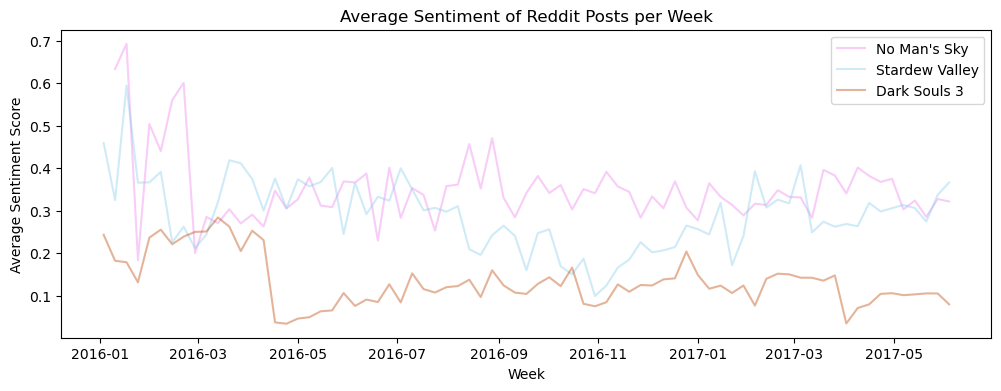

In [ ]:
sentiments_list = [stardewvalley_sentiment, no_mans_sky_sentiment, darksouls3_sentiment]

plt.figure(figsize=(12,4))
for i in range(3):
    s = sentiments_list[i]
    s['created_utc'] = pd.to_datetime(s['created_utc'])
    plt.plot(s.groupby([pd.Grouper(key='created_utc', freq='W')])["compound"].mean(), color=colors[i], alpha=0.4)

plt.xlabel("Week")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment of Reddit Posts per Week")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()

In [ ]:
def clean_input_data(data, sentiment):
    data_group = data.groupby([pd.Grouper(key='created_utc', freq='D')])
    
    num_posts = data_group["id"].count()
    num_comments = data_group["num_comments"].sum()
    score = data_group["score"].mean()

    sentiment_group = sentiment.groupby([pd.Grouper(key='created_utc', freq='M')])
    sentiment_score = sentiment_group["compound"].mean()
    avg_length = sentiment_group["length"].mean()

    temp_df = pd.DataFrame({"num_posts": num_posts, "num_comments": num_comments, "average_score":score, "sentiment":sentiment_score, "average_length": avg_length})
    temp_df['created_utc'] = pd.to_datetime(temp_df.index)
    temp_df.index = range(len(temp_df))
    temp_df = temp_df.fillna(0)
    # temp_df.index = temp_df.index.to_period('M').to_timestamp()
    return temp_df
  
stardewvalley_x = clean_input_data(stardewvalley_posts, stardewvalley_sentiment)
no_mans_sky_x = clean_input_data(no_mans_sky_posts, no_mans_sky_sentiment)
darksouls3_x = clean_input_data(darksouls3_posts, darksouls3_sentiment)

stardewvalley_data = pd.merge(stardewvalley_x, stardewvalley_y, left_on='created_utc', right_on='DateTime', how="inner")
stardewvalley_data = stardewvalley_data.drop(columns=["DateTime", "Average Players"])
no_mans_sky_data = pd.merge(no_mans_sky_x, no_mans_sky_y, left_on='created_utc', right_on='DateTime', how="inner")
no_mans_sky_data = no_mans_sky_data.drop(columns=["DateTime", "Average Players"])
darksouls3_data = pd.merge(darksouls3_x, darksouls3_y, left_on='created_utc', right_on='DateTime', how="inner")
darksouls3_data = darksouls3_data.drop(columns=["DateTime", "Average Players"])

/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/1089090625.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  stardewvalley_heatmap = sns.heatmap(stardewvalley_data.corr(), annot=True)


Text(0.5, 1.0, 'Stardewvalley Correlation Heatmap')

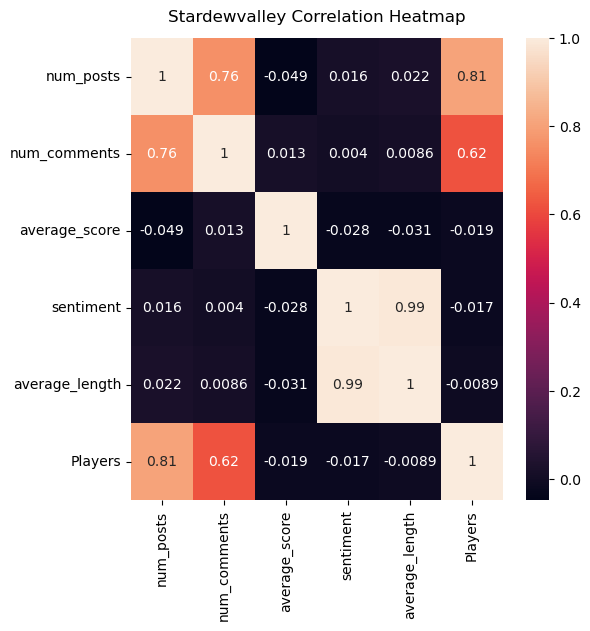

In [ ]:
plt.figure(figsize=(6, 6))
stardewvalley_heatmap = sns.heatmap(stardewvalley_data.corr(), annot=True)
stardewvalley_heatmap.set_title('Stardewvalley Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/2599312827.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  no_mans_sky_heatmap = sns.heatmap(no_mans_sky_data.corr(), annot=True)


Text(0.5, 1.0, 'No Mans Sky Correlation Heatmap')

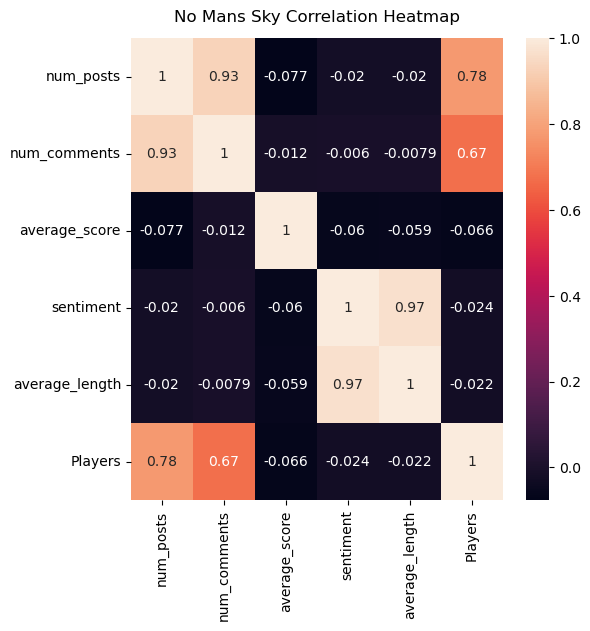

In [ ]:
plt.figure(figsize=(6, 6))
no_mans_sky_heatmap = sns.heatmap(no_mans_sky_data.corr(), annot=True)
no_mans_sky_heatmap.set_title('No Mans Sky Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/949200178.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  darksouls3_heatmap = sns.heatmap(darksouls3_data.corr(), annot=True)


Text(0.5, 1.0, 'Dark Souls 3 Correlation Heatmap')

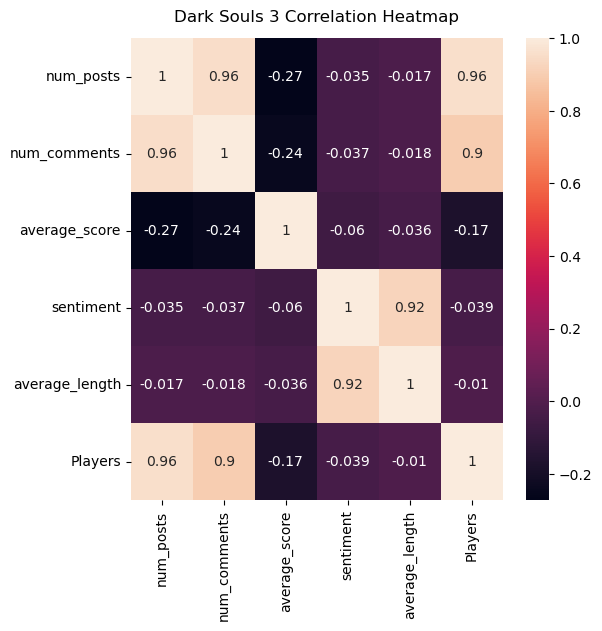

In [ ]:
plt.figure(figsize=(6, 6))
darksouls3_heatmap = sns.heatmap(darksouls3_data.corr(), annot=True)
darksouls3_heatmap.set_title('Dark Souls 3 Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
stardewvalley_sentiment = stardewvalley_sentiment.reset_index()

In [ ]:
worst_comment = stardewvalley_sentiment["Text"][stardewvalley_sentiment["compound"].argmin()]
print(worst_comment)

best_comment = stardewvalley_sentiment["Text"][stardewvalley_sentiment["compound"].argmax()]
print(best_comment)

This is a continuation of the series on my take of each of the eligible bachelors/bachelorettes in Stardew Valley. As usual, I'm not a professional counselor... it's just my opinion, and they're open to discussion and debate. :)

Sebastian is a homicidal rage machine that wants to die. Do I have your attention?

Sebastian is a rebellious loner who is big into games, comics, and science fiction, works as a programmer, dresses like a goth rocker,  and lives in his parents' basement. Take a minute and absorb that little stereotype for a moment. Yeah, he's that guy. Ever wondered why some guys (and gals) end up like him? Let's take a look at Sebastian.

For those of you who read Maru's write-up, you know that she is a genius that is going to make a huge splash in this world. Imagine that you're her not-genius brother. In Maru's write-up, I mentioned that Maru was stable due to Robin's and Demetrius' good parenting, and that's true. That same good parenting, however, requires a LOT of atten

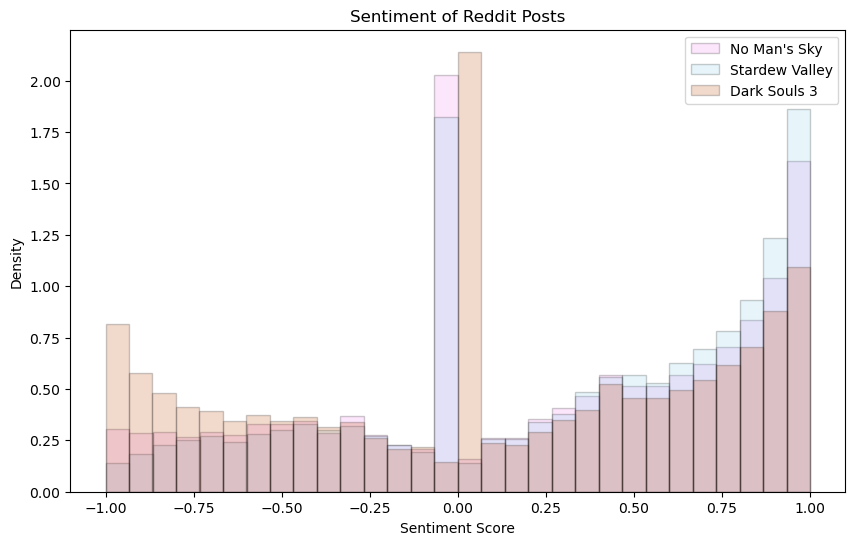

In [ ]:

plt.figure(figsize=(10,6))

plt.hist(no_mans_sky_sentiment["compound"], bins=30, color = "violet", ec="black", alpha=0.2, density=True)
plt.hist(stardewvalley_sentiment["compound"], bins=30, color = "skyblue", ec="black", alpha=0.2, density=True)
plt.hist(darksouls3_sentiment["compound"], bins=30, color = "#bd4404", ec="black", alpha=0.2, density=True)

plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.title("Sentiment of Reddit Posts")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()


## Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

import time

In [ ]:
default_models = [LinearRegression(), Ridge(), KNeighborsClassifier(), KNeighborsRegressor(),
                  tree.DecisionTreeClassifier(), RandomForestClassifier(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]

"""
Attempt various machine learning models and plot predicted values vs. true values of testing data set.
"""
def try_models(model_data, xcols, ycol, models=default_models):
    
    X = model_data[xcols]
    Y = model_data[ycol]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 20-80 train test split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    results = []
    mses = []
    
    fig, axs = plt.subplots(2, 4, figsize=(16,6))
    fig.suptitle(ycol)
    fig.tight_layout(h_pad=5, w_pad=2)
    fig.subplots_adjust(top=0.88)

    for i, model in enumerate(models):
        t1 = time.time()
        model.fit(X_train, Y_train)
        results.append(model)

        # store the predictions for the training and test set
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        # calculate error
                # calculate error
        error = pred_test - Y_test
        mse = round(sum(error**2) / len(error), 2)

        print(model)
        
        print("Training R^2 :", model.score(X_train, Y_train))
        print("Testing MSE:", mse)
        
        # print("Test Accuracy: ", accuracy_score(Y_test, pred_test))
        # print("Training Accuracy: ", accuracy_score(Y_train, pred_train))
        r = i//4
        c = i % 4
        t2 = time.time()
        print("Time:", t2-t1)
        # axs[r, c].hist(Y_test, alpha=0.6)
        # axs[r, c].hist(pred_test, alpha=0.6)
        axs[r,c].grid()
        axs[r,c].scatter(pred_test, Y_test, alpha=0.6)
        axs[r,c].scatter(pred_train, Y_train, alpha=0.6)
        axs[r,c].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], linestyle="--", color="grey")
        axs[r, c].set_title(str(model) + "\n testing mse: " + str(mse))
        mses.append(mse)
        print()
    plt.savefig('try_models.png')
    plt.show()
    return results, mses

In [ ]:
stardewvalley_data

,num_posts,num_comments,average_score,sentiment,average_length,created_utc,Players
0,1,34,32.000000,0.00000,0.000000,2016-01-04,1.0
1,1,5,18.000000,0.00000,0.000000,2016-01-05,2.0
2,0,0,0.000000,0.00000,0.000000,2016-01-06,1.0
3,1,20,27.000000,0.00000,0.000000,2016-01-07,3.0
4,0,0,0.000000,0.00000,0.000000,2016-01-08,2.0
...,...,...,...,...,...,...,...
509,12,133,30.250000,0.00000,0.000000,2017-05-27,10114.0
510,10,73,7.400000,0.00000,0.000000,2017-05-28,10590.0
511,22,195,8.318182,0.00000,0.000000,2017-05-29,9828.0
512,17,178,8.647059,0.00000,0.000000,2017-05-30,9030.0


In [ ]:
stardewvalley_data_cat = stardewvalley_data
stardewvalley_data_cat["subreddit"] = 0
no_mans_sky_data_cat = no_mans_sky_data
no_mans_sky_data_cat["subreddit"] = 1
darksouls3_data_cat = darksouls3_data
darksouls3_data_cat["subreddit"] = 2
all_data = pd.concat([stardewvalley_data_cat, no_mans_sky_data_cat, darksouls3_data_cat ])
all_data["created_utc"] = all_data["created_utc"].astype('int64')

Text(0.5, 1.0, 'All Games Correlation Heatmap')

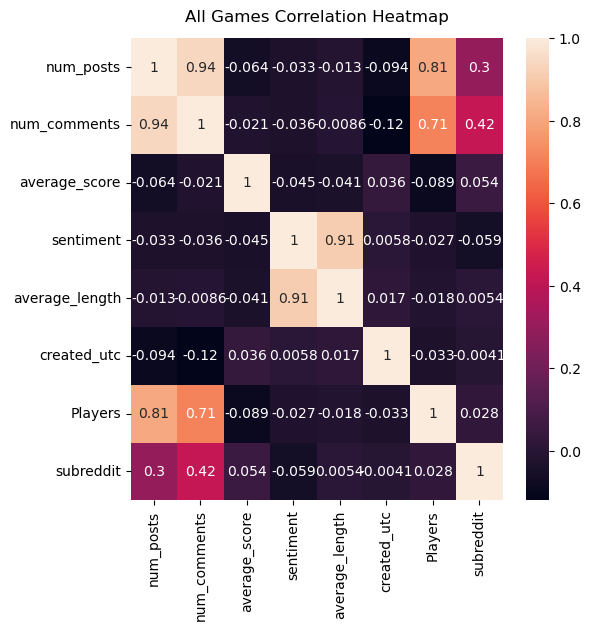

In [ ]:
plt.figure(figsize=(6,6))
all_data_heatmap = sns.heatmap(all_data.corr(), annot=True)
all_data_heatmap.set_title('All Games Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

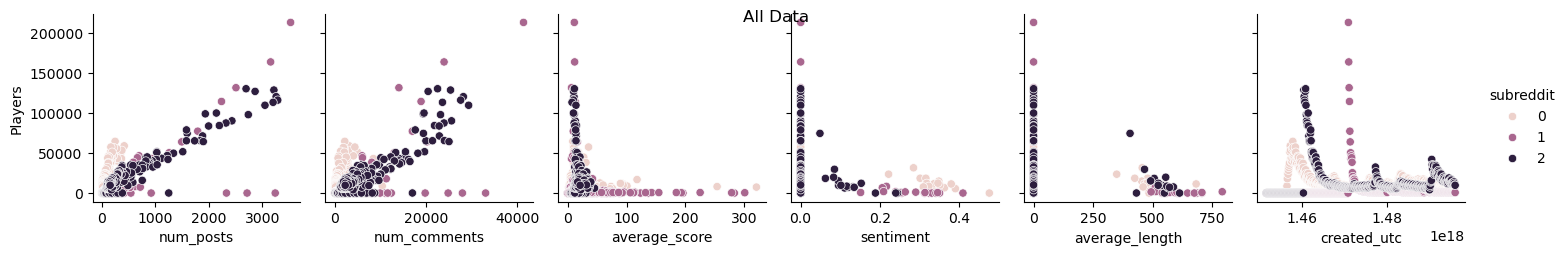

In [42]:
xcols = ['num_posts', 'num_comments', 'average_score', 'sentiment',
       'average_length', 'created_utc']
ycol = 'Players'
# sns.pairplot(data = stardewvalley_data, x_vars = xcols, y_vars = ycol, color="skyblue")
# plt.suptitle("Stardewvalley Data")
# plt.show()

sns.pairplot(data = all_data, x_vars = xcols, y_vars = ycol, hue="subreddit")
plt.suptitle("All Data")
plt.show()

LinearRegression()
Training R^2 : 0.6613906627194286
Testing MSE: 53618718.49
Time: 0.020430803298950195

Ridge()
Training R^2 : 0.6613775483060851
Testing MSE: 53602962.34
Time: 0.007118940353393555

KNeighborsRegressor()
Training R^2 : 0.8143532313738326
Testing MSE: 26247721.04
Time: 0.02330613136291504

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 34975729.27
Time: 0.014920949935913086

RandomForestRegressor()
Training R^2 : 0.9659482370915577
Testing MSE: 18102813.5
Time: 0.5003180503845215



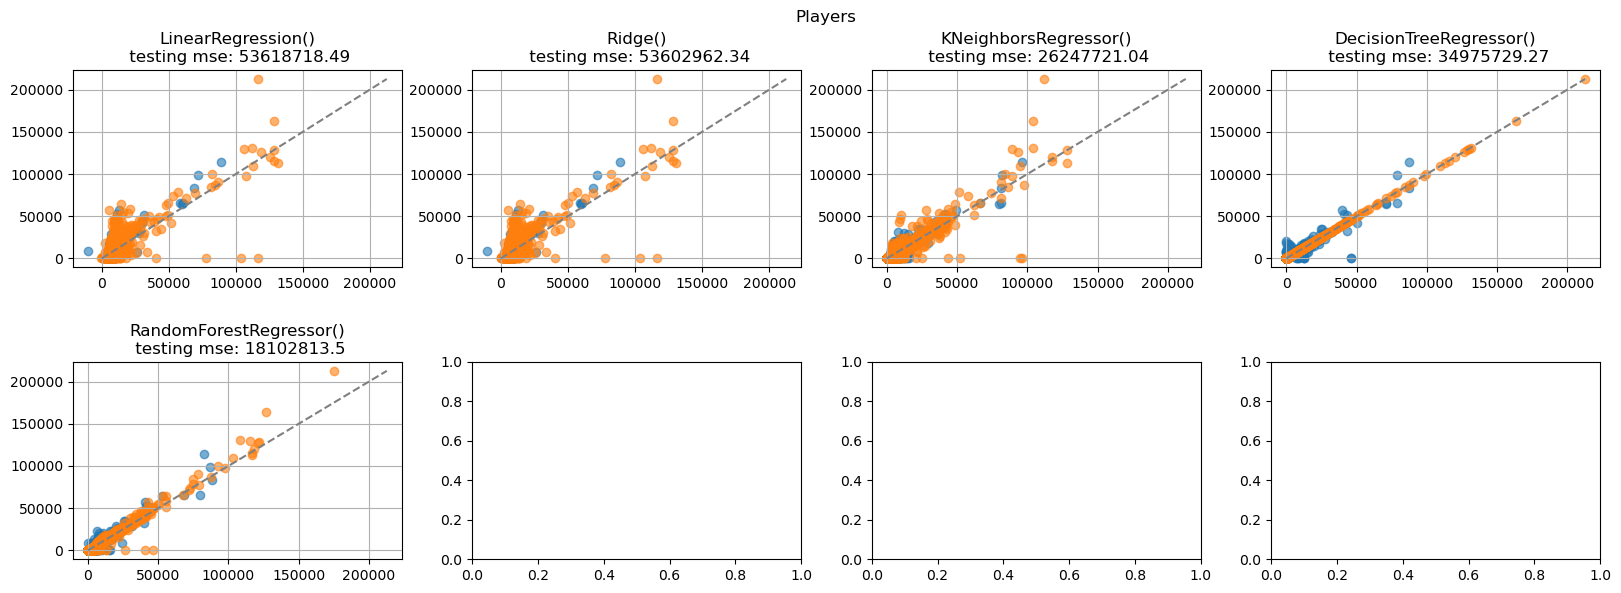

In [44]:
default_models = [LinearRegression(), Ridge(), KNeighborsRegressor(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]
models, mses = try_models(all_data, xcols, ycol, default_models)

LinearRegression()
Training R^2 : 0.6527672924130681
Testing MSE: 30838166.89
Time: 0.0022857189178466797

Ridge()
Training R^2 : 0.652751790063673
Testing MSE: 30901923.71
Time: 0.002251148223876953

KNeighborsRegressor()
Training R^2 : 0.8706763780511981
Testing MSE: 9686809.92
Time: 0.00582575798034668

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 10256498.79
Time: 0.003154277801513672

RandomForestRegressor()
Training R^2 : 0.9900425421733099
Testing MSE: 7115839.39
Time: 0.17377781867980957



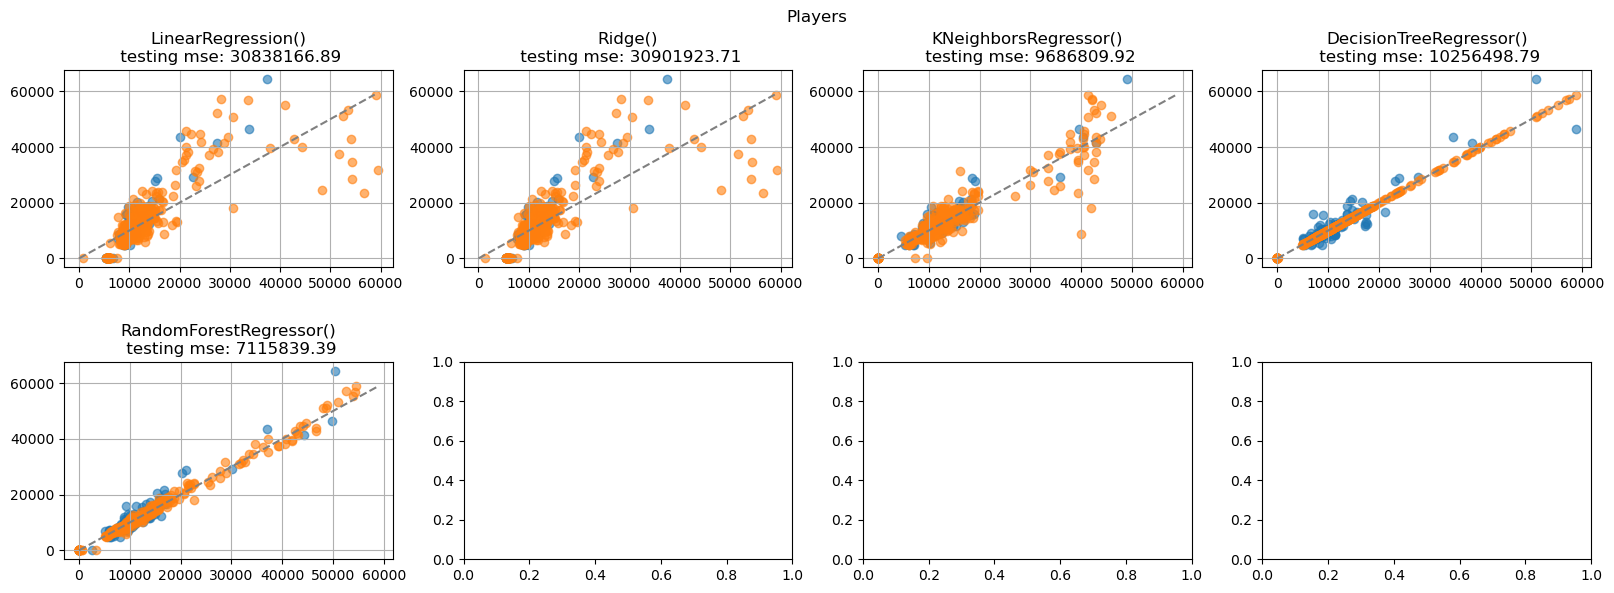

In [45]:
stardewvalley_mod_data = stardewvalley_data
stardewvalley_mod_data["created_utc"] = stardewvalley_mod_data["created_utc"].astype('int64')
stardewvalley_models, stardewvalley_mses = try_models(stardewvalley_mod_data, xcols, ycol, default_models)

LinearRegression()
Training R^2 : 0.5882005388618878
Testing MSE: 196649050.97
Time: 0.002521991729736328

Ridge()
Training R^2 : 0.5880482847985278
Testing MSE: 195292162.99
Time: 0.0014739036560058594

KNeighborsRegressor()
Training R^2 : 0.6286697967357346
Testing MSE: 246166227.88
Time: 0.005480766296386719

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 434941762.52
Time: 0.0035681724548339844

RandomForestRegressor()
Training R^2 : 0.9202181782402485
Testing MSE: 271345267.16
Time: 0.1602330207824707



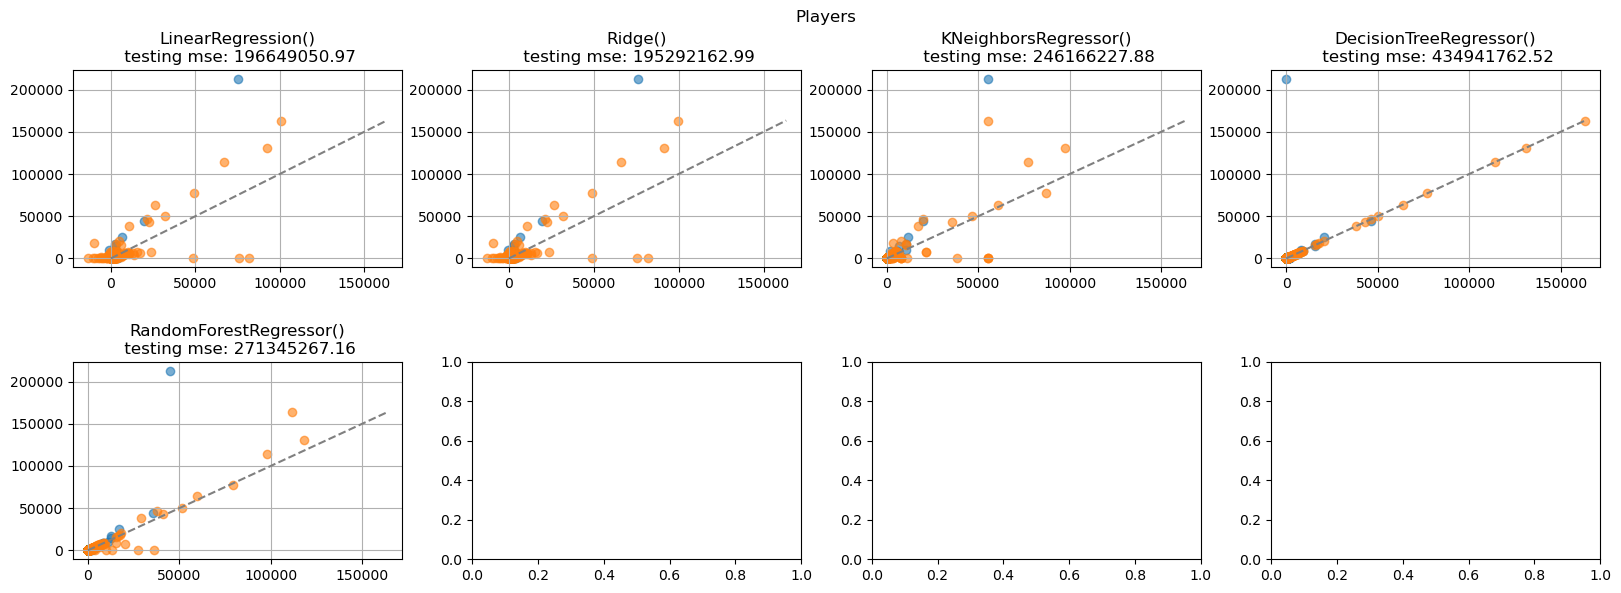

In [46]:
no_mans_sky_mod_data = no_mans_sky_data
no_mans_sky_mod_data["created_utc"] = no_mans_sky_mod_data["created_utc"].astype('int64')
no_mans_sky_models, no_mans_sky_mses = try_models(no_mans_sky_mod_data, xcols, ycol, default_models)

In [ ]:
dark_souls_3_mod_data = darksouls3_data
dark_souls_3_mod_data["created_utc"] = dark_souls_3_mod_data["created_utc"].astype('int64')
dark_souls_3_models, dark_souls_3_mses = try_models(dark_souls_3_mod_data, xcols, ycol, default_models)

In [47]:
forrest_model = models[-1]

num_posts         0.687466
created_utc       0.163439
num_comments      0.108954
average_score     0.040100
average_length    0.000041
sentiment         0.000001
dtype: float64

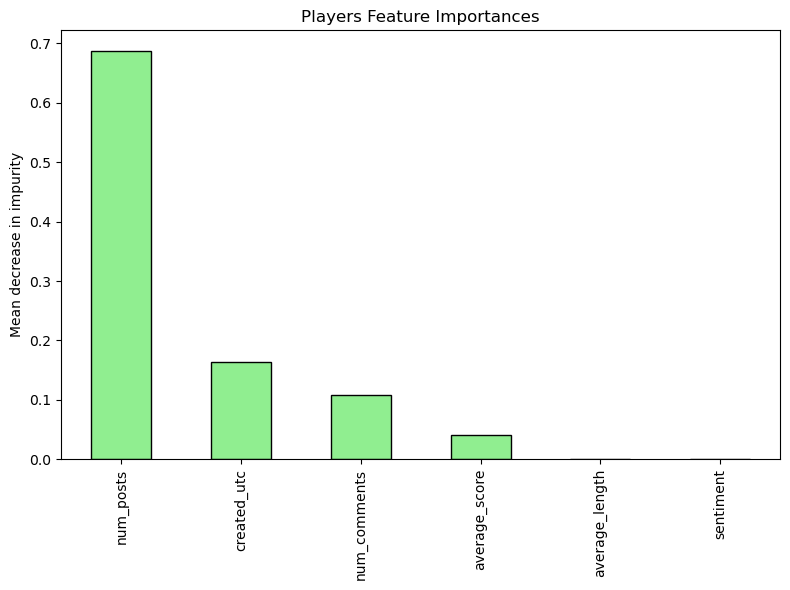

In [48]:
def MIDI_graph(model, feature_names, yname, n=None, plot=False):
    if n ==  None:
        n = len(feature_names)

    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)[0:n]

    fig, ax = plt.subplots(figsize=(8, 6))
    forest_importances.plot.bar(ax=ax, color = "lightgreen", ec="black")
    ax.set_title("{} Feature Importances".format(yname))
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

MIDI_graph(forrest_model, xcols, ycol)

### Load Input Data (Subreddit comments)

In [51]:
# comments = pd.read_json('filtered_comment_combined.jsonl', lines=True)

# comments["created_utc"] = pd.to_datetime(comments["created_utc"], unit='s')
comments = comments.loc[comments['body'] != '[removed]']
comments = comments.loc[comments['body'] != '[deleted]']
comments = comments.loc[comments['body'] != '']
comments = comments.reset_index()

In [52]:
print(len(comments))

4475317


In [64]:
def get_sentiment(data):
    sia = SentimentIntensityAnalyzer()
    negative = []
    neutral = []
    positive = []
    compound = []
    length = []
    subreddit = []
    for i in tqdm(range(len(data["body"]))):
        txt = data["body"][i]
        subreddit.append(data["subreddit"][i])
        result = sia.polarity_scores(txt)
        negative.append(result['neg'])
        positive.append(result['pos'])
        neutral.append(result['neu'])
        compound.append(result['compound'])
        length.append(len(txt))

    sentiment_df = pd.DataFrame({"created_utc": list(data["created_utc"]), "subreddit":subreddit,"Text": list(data["body"]), "negative": negative, "neutral":neutral, "positive": positive, "compound":compound, "length":length})
    return sentiment_df

sentiment = get_sentiment(comments)
sentiment.to_csv("comm_sentiment.csv")

sentiment = pd.read_csv("comm_sentiment.csv")

100%|██████████| 4475317/4475317 [18:53<00:00, 3946.50it/s]
/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/1743598880.py:25: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiment = pd.read_csv("comm_sentiment.csv")


In [65]:
print(sentiment.head())

  Unnamed: 0          created_utc         subreddit  \
0          0  2016-01-01 00:07:26        darksouls3   
1          1  2016-01-01 00:14:53        darksouls3   
2          2  2016-01-01 00:17:54  NoMansSkyTheGame   
3          3  2016-01-01 00:19:15        darksouls3   
4          4  2016-01-01 00:20:31        darksouls3   

                                                Text  negative  neutral  \
0  &gt; Xbone has like nothing to offer.\n\nI don...     0.000    0.808   
1  I was going to ask if we were just talking gra...     0.000    0.877   
2  Thanks! It was something I've worked on since ...     0.032    0.702   
3  You should at least be allowed to use the item...     0.000    1.000   
4  But it was also English dubbed first (as in, t...     0.000    1.000   

   positive  compound  length  
0     0.192    0.7096   187.0  
1     0.123    0.8316   396.0  
2     0.266    0.9430   312.0  
3     0.000    0.0000    81.0  
4     0.000    0.0000   196.0  


In [66]:
stardewvalley_comments = comments.loc[comments['subreddit'] == 'StardewValley']
stardewvalley_sentiment = sentiment.loc[sentiment['subreddit'] == 'StardewValley']

no_mans_sky_comments = comments.loc[comments['subreddit'] == 'NoMansSkyTheGame']
no_mans_sky_sentiment = sentiment.loc[sentiment['subreddit'] == 'NoMansSkyTheGame']

darksouls3_comments = comments.loc[comments['subreddit'] == 'darksouls3']
darksouls3_sentiment = sentiment.loc[sentiment['subreddit'] == 'darksouls3']

In [67]:
darksouls3_sentiment

,Unnamed: 0,created_utc,subreddit,Text,negative,neutral,positive,compound,length
0,0,2016-01-01 00:07:26,darksouls3,&gt; Xbone has like nothing to offer.\n\nI don...,0.000,0.808,0.192,0.7096,187.0
1,1,2016-01-01 00:14:53,darksouls3,I was going to ask if we were just talking gra...,0.000,0.877,0.123,0.8316,396.0
3,3,2016-01-01 00:19:15,darksouls3,You should at least be allowed to use the item...,0.000,1.000,0.000,0.0000,81.0
4,4,2016-01-01 00:20:31,darksouls3,"But it was also English dubbed first (as in, t...",0.000,1.000,0.000,0.0000,196.0
5,5,2016-01-01 00:24:21,darksouls3,That actually sounds pretty awesome. I imagin...,0.000,0.573,0.427,0.8658,97.0
...,...,...,...,...,...,...,...,...,...
4980899,4475311,2017-05-31 23:58:32,darksouls3,DSA?,0.000,1.000,0.000,0.0000,4.0
4980900,4475312,2017-05-31 23:58:39,darksouls3,"I used to duel a lot, but I just can't stand i...",0.072,0.793,0.136,0.3612,194.0
4980902,4475314,2017-05-31 23:59:03,darksouls3,Was definitely hardest NPC for me to kill in g...,0.129,0.658,0.214,0.2732,149.0
4980903,4475315,2017-05-31 23:59:10,darksouls3,If you do let me know :) i can tell you +4 and...,0.000,0.859,0.141,0.8126,267.0


/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/760960037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['created_utc'] = pd.to_datetime(s['created_utc'])
/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/760960037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['created_utc'] = pd.to_datetime(s['created_utc'])
/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/760960037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

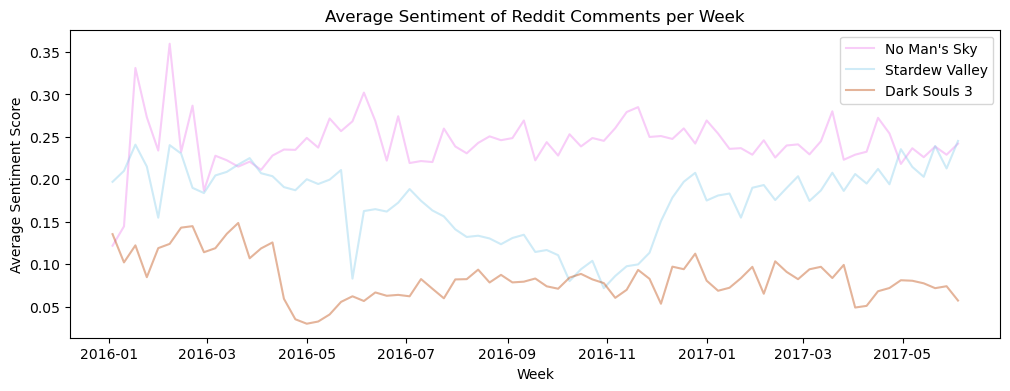

In [68]:
sentiments_list = [stardewvalley_sentiment, no_mans_sky_sentiment, darksouls3_sentiment]

plt.figure(figsize=(12,4))
for i in range(3):
    s = sentiments_list[i]
    s['created_utc'] = pd.to_datetime(s['created_utc'])
    plt.plot(s.groupby([pd.Grouper(key='created_utc', freq='W')])["compound"].mean(), color=colors[i], alpha=0.4)

plt.xlabel("Week")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment of Reddit Comments per Week")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()

In [69]:
def clean_input_data(data, sentiment):
    data_group = data.groupby([pd.Grouper(key='created_utc', freq='D')])
    
    num_comments = data_group["id"].count()
    score = data_group["score"].mean()

    sentiment_group = sentiment.groupby([pd.Grouper(key='created_utc', freq='M')])
    sentiment_score = sentiment_group["compound"].mean()
    avg_length = sentiment_group["length"].mean()

    temp_df = pd.DataFrame({"num_comments": num_comments, "average_score":score, "sentiment":sentiment_score, "average_length": avg_length})
    temp_df['created_utc'] = pd.to_datetime(temp_df.index)
    temp_df.index = range(len(temp_df))
    temp_df = temp_df.fillna(0)
    # temp_df.index = temp_df.index.to_period('M').to_timestamp()
    return temp_df
  
stardewvalley_x = clean_input_data(stardewvalley_comments, stardewvalley_sentiment)
no_mans_sky_x = clean_input_data(no_mans_sky_comments, no_mans_sky_sentiment)
darksouls3_x = clean_input_data(darksouls3_comments, darksouls3_sentiment)

stardewvalley_data = pd.merge(stardewvalley_x, stardewvalley_y, left_on='created_utc', right_on='DateTime', how="inner")
stardewvalley_data = stardewvalley_data.drop(columns=["DateTime", "Average Players"])
no_mans_sky_data = pd.merge(no_mans_sky_x, no_mans_sky_y, left_on='created_utc', right_on='DateTime', how="inner")
no_mans_sky_data = no_mans_sky_data.drop(columns=["DateTime", "Average Players"])
darksouls3_data = pd.merge(darksouls3_x, darksouls3_y, left_on='created_utc', right_on='DateTime', how="inner")
darksouls3_data = darksouls3_data.drop(columns=["DateTime", "Average Players"])

/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/1089090625.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  stardewvalley_heatmap = sns.heatmap(stardewvalley_data.corr(), annot=True)


Text(0.5, 1.0, 'Stardewvalley Correlation Heatmap')

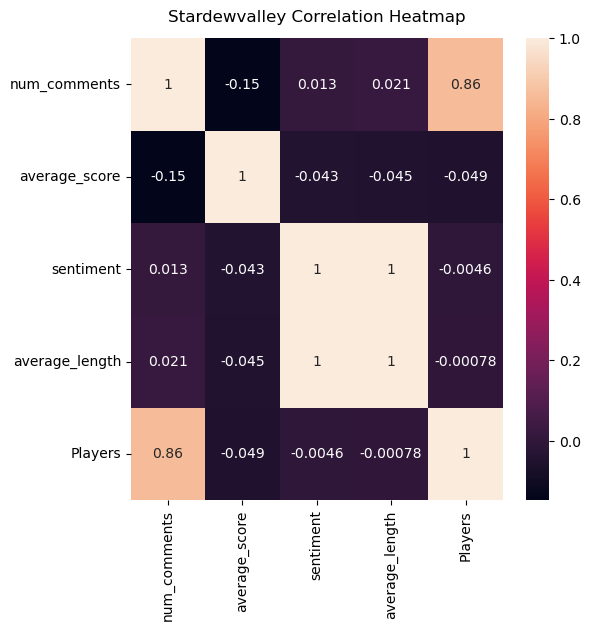

In [70]:
plt.figure(figsize=(6, 6))
stardewvalley_heatmap = sns.heatmap(stardewvalley_data.corr(), annot=True)
stardewvalley_heatmap.set_title('Stardewvalley Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/2599312827.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  no_mans_sky_heatmap = sns.heatmap(no_mans_sky_data.corr(), annot=True)


Text(0.5, 1.0, 'No Mans Sky Correlation Heatmap')

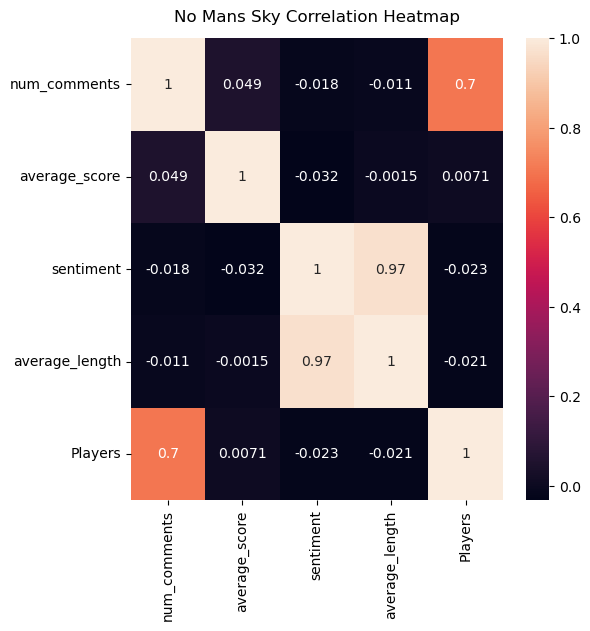

In [71]:
plt.figure(figsize=(6, 6))
no_mans_sky_heatmap = sns.heatmap(no_mans_sky_data.corr(), annot=True)
no_mans_sky_heatmap.set_title('No Mans Sky Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

/var/folders/5_/dt33xgsj1wx5v93fjbsvgqy80000gn/T/ipykernel_55593/949200178.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  darksouls3_heatmap = sns.heatmap(darksouls3_data.corr(), annot=True)


Text(0.5, 1.0, 'Dark Souls 3 Correlation Heatmap')

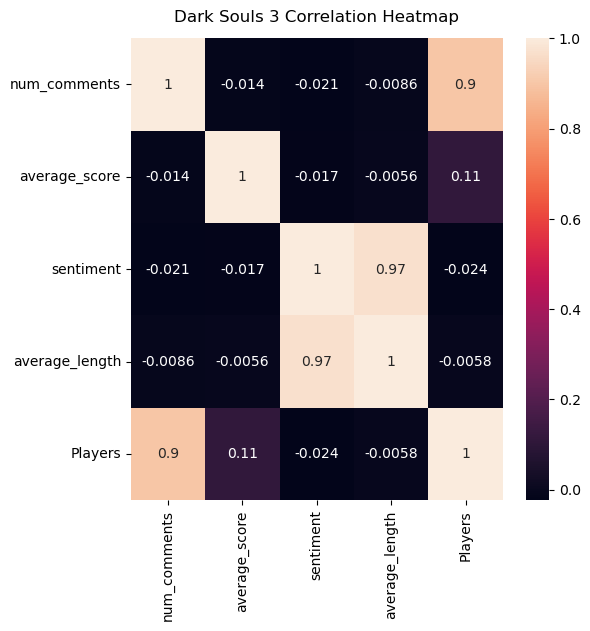

In [72]:
plt.figure(figsize=(6, 6))
darksouls3_heatmap = sns.heatmap(darksouls3_data.corr(), annot=True)
darksouls3_heatmap.set_title('Dark Souls 3 Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [81]:
stardewvalley_sentiment = stardewvalley_sentiment.reset_index()

best_comment = stardewvalley_sentiment["Text"][stardewvalley_sentiment["compound"].argmax()]
print(best_comment)

I totally recognize that first shed~   
I have some amount of praise to sing about each of them (aside from the first one as I've already seen it) so bare with me--but I feel it's only fitting: I'm sure some (if not all) of these took a lot of effort~

* Festive / Winter Shed: Super aesthetically pleasing. I just really dig everything about this shed. Granted, I wish the crystal floor did a better job of emulating ice but it definitely is the closest you're going to get xD Btw, I oddly love your character in the ear muffs also for whatever reason? It's a good look.
* Tea Room: Kinda makes me wish I drank tea (and was an NPC living in your game of SDV that was *also* good enough friends with you and sentient enough to ask to come over and sit in your tea shed).
*Fish Shop: The aesthetic really matches the theme--and I'm sorry about the angler fish. I know those feels.
* Pirate Shed: My favorite thus far. Aside from the fact that pirates are awesome, you really nailed the Captain's Quart

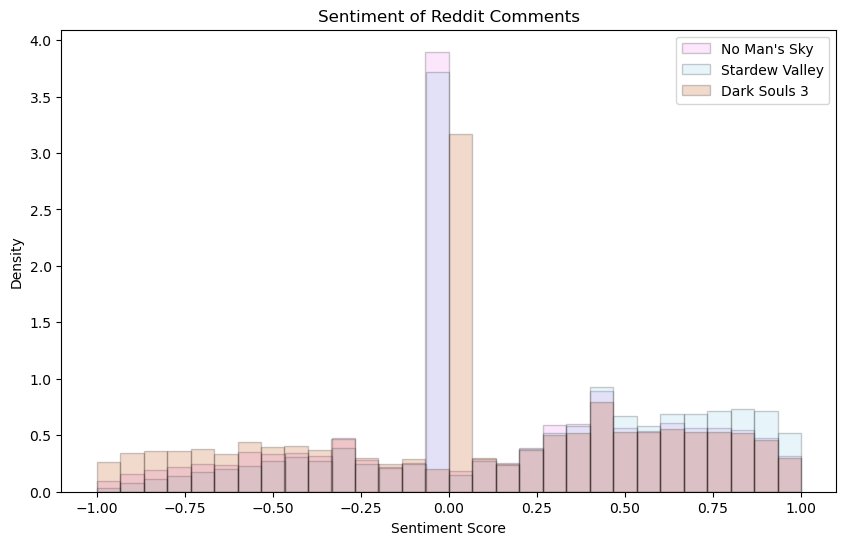

In [74]:
plt.figure(figsize=(10,6))

plt.hist(no_mans_sky_sentiment["compound"], bins=30, color = "violet", ec="black", alpha=0.2, density=True)
plt.hist(stardewvalley_sentiment["compound"], bins=30, color = "skyblue", ec="black", alpha=0.2, density=True)
plt.hist(darksouls3_sentiment["compound"], bins=30, color = "#bd4404", ec="black", alpha=0.2, density=True)

plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.title("Sentiment of Reddit Comments")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()


### Comment Modelling

In [75]:
default_models = [LinearRegression(), Ridge(), KNeighborsClassifier(), KNeighborsRegressor(),
                  tree.DecisionTreeClassifier(), RandomForestClassifier(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]

"""
Attempt various machine learning models and plot predicted values vs. true values of testing data set.
"""
def try_models(model_data, xcols, ycol, models=default_models):
    
    X = model_data[xcols]
    Y = model_data[ycol]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 20-80 train test split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    results = []
    mses = []
    
    fig, axs = plt.subplots(2, 4, figsize=(16,6))
    fig.suptitle(ycol)
    fig.tight_layout(h_pad=5, w_pad=2)
    fig.subplots_adjust(top=0.88)

    for i, model in enumerate(models):
        t1 = time.time()
        model.fit(X_train, Y_train)
        results.append(model)

        # store the predictions for the training and test set
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        # calculate error
                # calculate error
        error = pred_test - Y_test
        mse = round(sum(error**2) / len(error), 2)

        print(model)
        
        print("Training R^2 :", model.score(X_train, Y_train))
        print("Testing MSE:", mse)
        
        # print("Test Accuracy: ", accuracy_score(Y_test, pred_test))
        # print("Training Accuracy: ", accuracy_score(Y_train, pred_train))
        r = i//4
        c = i % 4
        t2 = time.time()
        print("Time:", t2-t1)
        # axs[r, c].hist(Y_test, alpha=0.6)
        # axs[r, c].hist(pred_test, alpha=0.6)
        axs[r,c].grid()
        axs[r,c].scatter(pred_test, Y_test, alpha=0.6)
        axs[r,c].scatter(pred_train, Y_train, alpha=0.6)
        axs[r,c].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], linestyle="--", color="grey")
        axs[r, c].set_title(str(model) + "\n testing mse: " + str(mse))
        mses.append(mse)
        print()
    plt.savefig('try_models.png')
    plt.show()
    return results, mses

In [76]:
stardewvalley_data

,num_comments,average_score,sentiment,average_length,created_utc,Players
0,2,2.500000,0.000000,0.000000,2016-01-01,3.0
1,17,5.588235,0.000000,0.000000,2016-01-02,2.0
2,1,3.000000,0.000000,0.000000,2016-01-03,2.0
3,3,2.000000,0.000000,0.000000,2016-01-04,1.0
4,28,5.928571,0.000000,0.000000,2016-01-05,2.0
...,...,...,...,...,...,...
512,180,5.600000,0.000000,0.000000,2017-05-27,10114.0
513,199,7.708543,0.000000,0.000000,2017-05-28,10590.0
514,262,8.698473,0.000000,0.000000,2017-05-29,9828.0
515,337,6.732938,0.000000,0.000000,2017-05-30,9030.0


In [77]:
stardewvalley_data_cat = stardewvalley_data
stardewvalley_data_cat["subreddit"] = 0
no_mans_sky_data_cat = no_mans_sky_data
no_mans_sky_data_cat["subreddit"] = 1
darksouls3_data_cat = darksouls3_data
darksouls3_data_cat["subreddit"] = 2
all_data = pd.concat([stardewvalley_data_cat, no_mans_sky_data_cat, darksouls3_data_cat ])
all_data["created_utc"] = all_data["created_utc"].astype('int64')

Text(0.5, 1.0, 'All Games Correlation Heatmap')

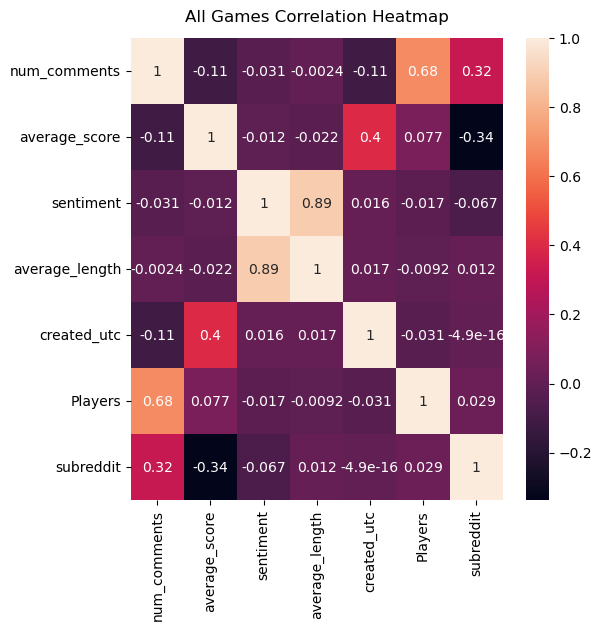

In [78]:
plt.figure(figsize=(6,6))
all_data_heatmap = sns.heatmap(all_data.corr(), annot=True)
all_data_heatmap.set_title('All Games Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

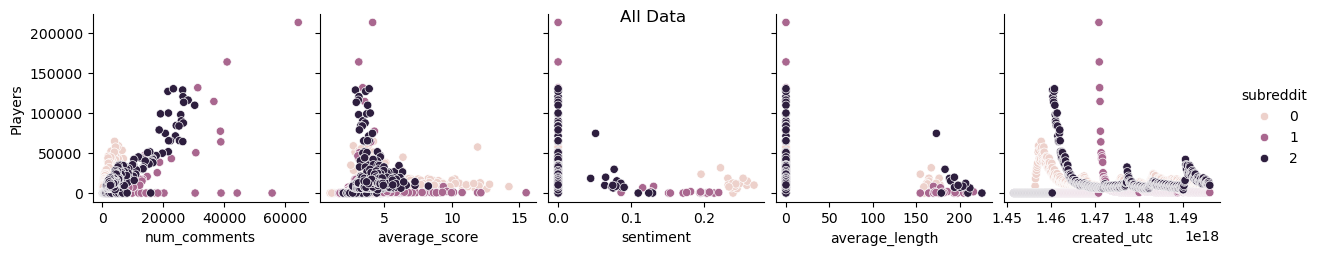

In [79]:
xcols = ['num_comments', 'average_score', 'sentiment',
       'average_length', 'created_utc']
ycol = 'Players'

sns.pairplot(data = all_data, x_vars = xcols, y_vars = ycol, hue="subreddit")
plt.suptitle("All Data")
plt.show()

LinearRegression()
Training R^2 : 0.5244401599507049
Testing MSE: 145235109.8
Time: 0.025685787200927734

Ridge()
Training R^2 : 0.5244398061983939
Testing MSE: 145205912.93
Time: 0.005343914031982422

KNeighborsRegressor()
Training R^2 : 0.7511032186496184
Testing MSE: 77838019.09
Time: 0.026168107986450195

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 67490700.89
Time: 0.01504206657409668

RandomForestRegressor()
Training R^2 : 0.9537695176036205
Testing MSE: 58728197.66
Time: 0.34624290466308594



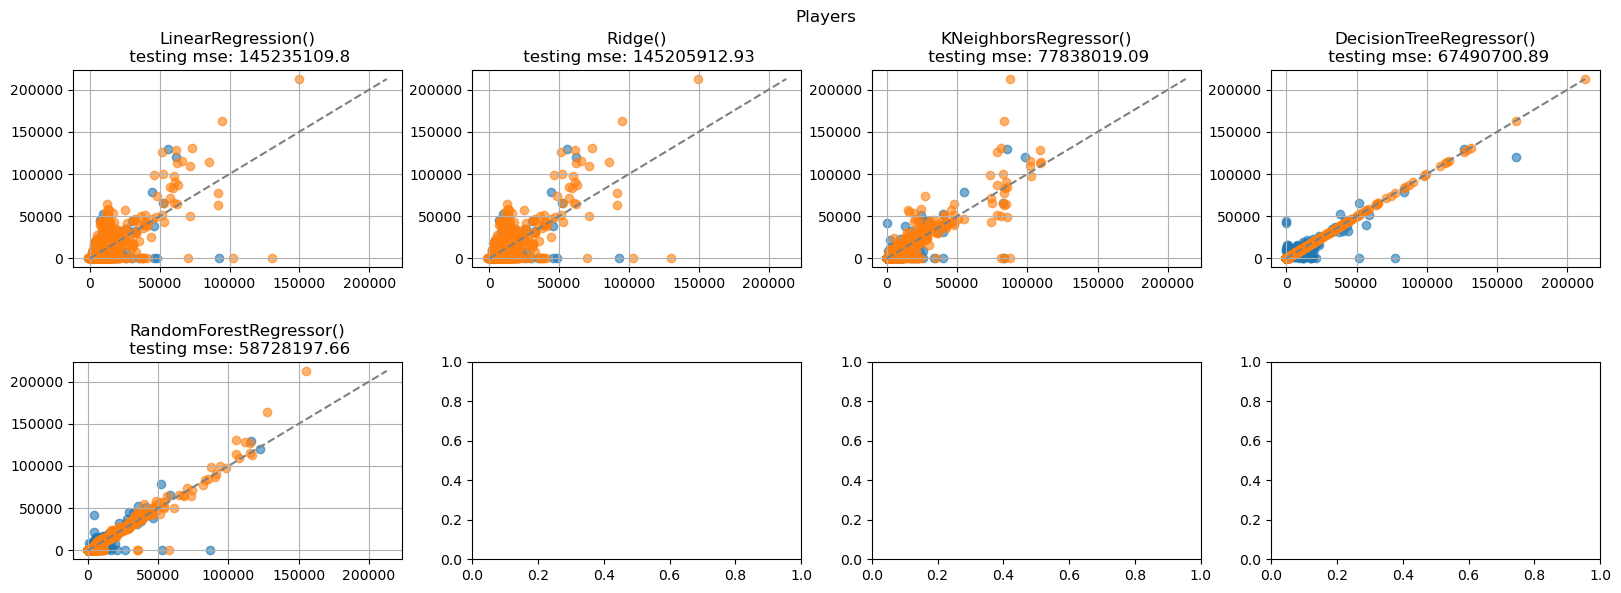

In [80]:


default_models = [LinearRegression(), Ridge(), KNeighborsRegressor(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]
models, mses = try_models(all_data, xcols, ycol, default_models)

LinearRegression()
Training R^2 : 0.7569244249874367
Testing MSE: 27297163.36
Time: 0.008095979690551758

Ridge()
Training R^2 : 0.755689889216939
Testing MSE: 27537612.55
Time: 0.002670764923095703

KNeighborsRegressor()
Training R^2 : 0.871359120757136
Testing MSE: 19290575.41
Time: 0.006675004959106445

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 15366188.61
Time: 0.005475044250488281

RandomForestRegressor()
Training R^2 : 0.9860697295075075
Testing MSE: 7996921.47
Time: 0.1188960075378418



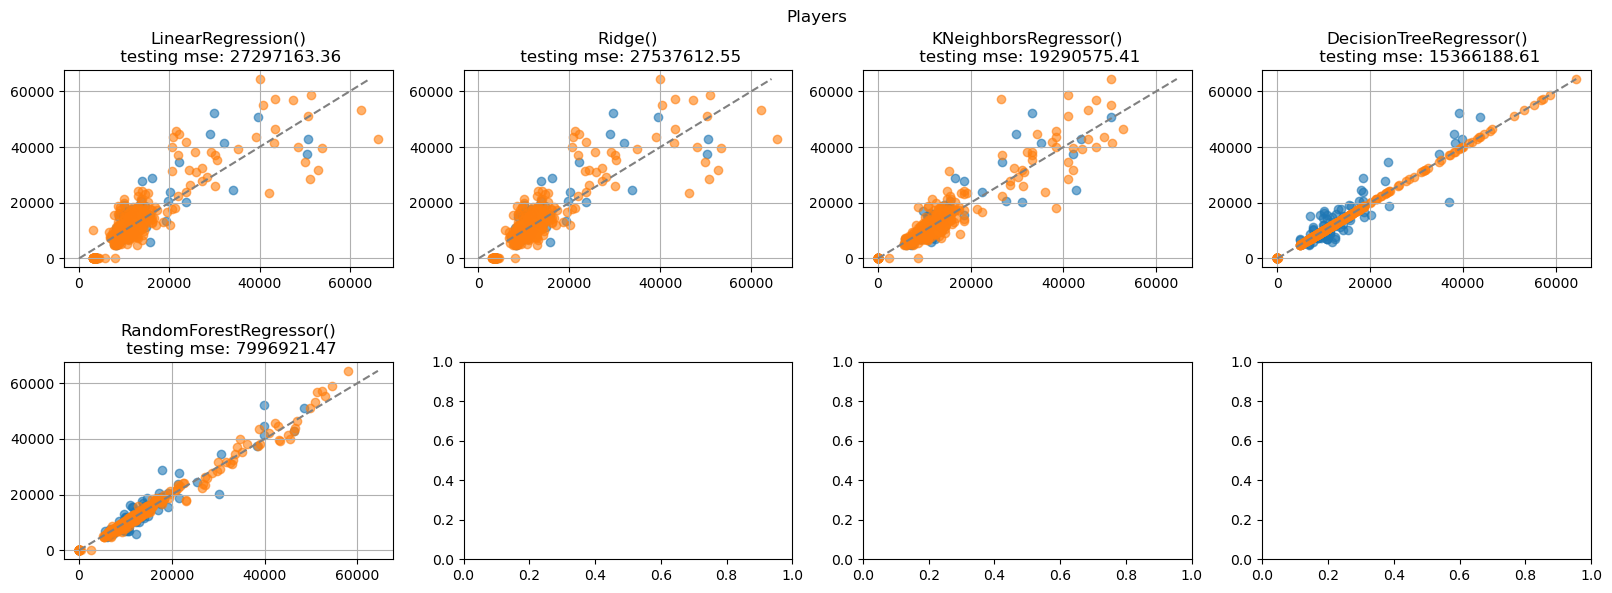

In [82]:
stardewvalley_mod_data = stardewvalley_data
stardewvalley_mod_data["created_utc"] = stardewvalley_mod_data["created_utc"].astype('int64')
stardewvalley_models, stardewvalley_mses = try_models(stardewvalley_mod_data, xcols, ycol, default_models)

LinearRegression()
Training R^2 : 0.5971024208062069
Testing MSE: 153504509.46
Time: 0.01149892807006836

Ridge()
Training R^2 : 0.5970984607145231
Testing MSE: 152747402.51
Time: 0.005499124526977539

KNeighborsRegressor()
Training R^2 : 0.6022222862147137
Testing MSE: 94061045.2
Time: 0.011330127716064453

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 1489391.68
Time: 0.009099006652832031

RandomForestRegressor()
Training R^2 : 0.9236341242348601
Testing MSE: 112481266.07
Time: 0.09329080581665039



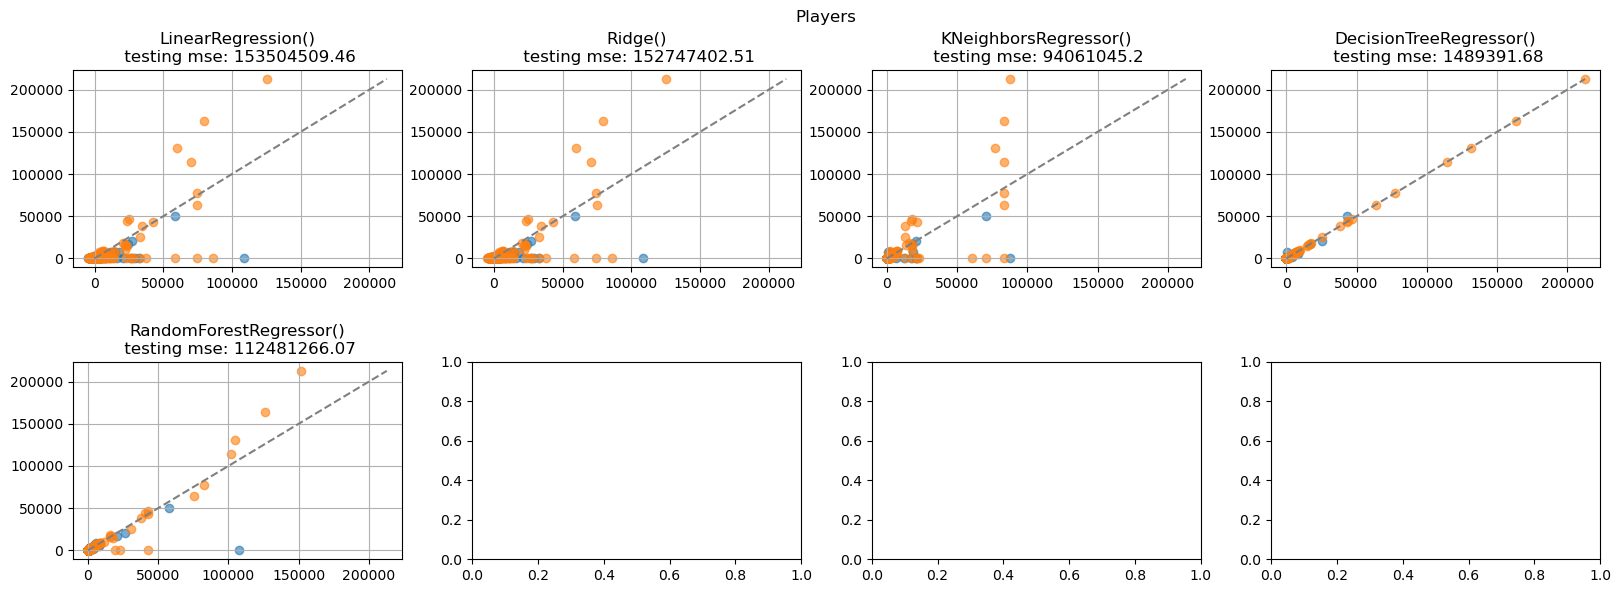

In [83]:
no_mans_sky_mod_data = no_mans_sky_data
no_mans_sky_mod_data["created_utc"] = no_mans_sky_mod_data["created_utc"].astype('int64')
no_mans_sky_models, no_mans_sky_mses = try_models(no_mans_sky_mod_data, xcols, ycol, default_models)

LinearRegression()
Training R^2 : 0.8339875474984245
Testing MSE: 73654049.2
Time: 0.001856088638305664

Ridge()
Training R^2 : 0.8339795302025648
Testing MSE: 73494298.56
Time: 0.0012500286102294922

KNeighborsRegressor()
Training R^2 : 0.9152744991594184
Testing MSE: 57169816.65
Time: 0.0037529468536376953

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 66438039.11
Time: 0.002334117889404297

RandomForestRegressor()
Training R^2 : 0.9950465728769516
Testing MSE: 56431935.28
Time: 0.10479211807250977



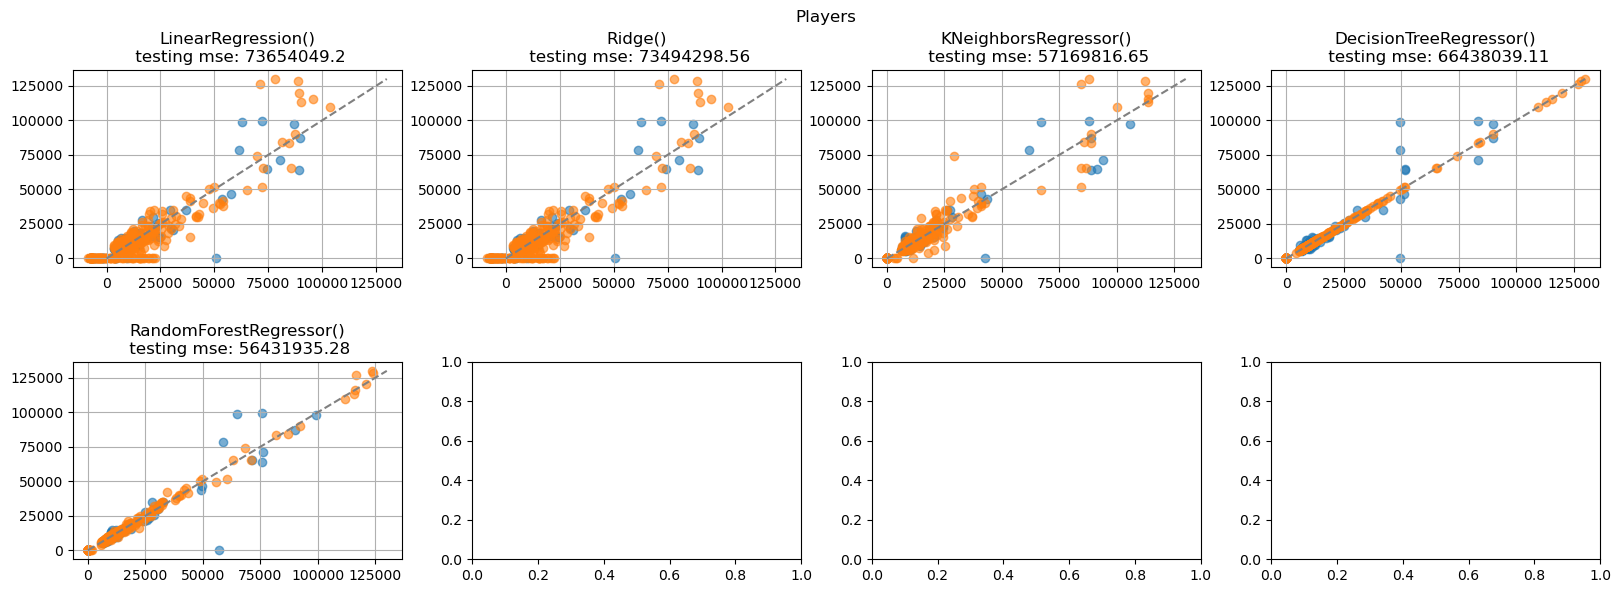

In [84]:
dark_souls_3_mod_data = darksouls3_data
dark_souls_3_mod_data["created_utc"] = dark_souls_3_mod_data["created_utc"].astype('int64')
dark_souls_3_models, dark_souls_3_mses = try_models(dark_souls_3_mod_data, xcols, ycol, default_models)

In [85]:
forrest_model = models[-1]

num_comments      0.814349
created_utc       0.176550
average_score     0.008736
average_length    0.000194
sentiment         0.000172
dtype: float64

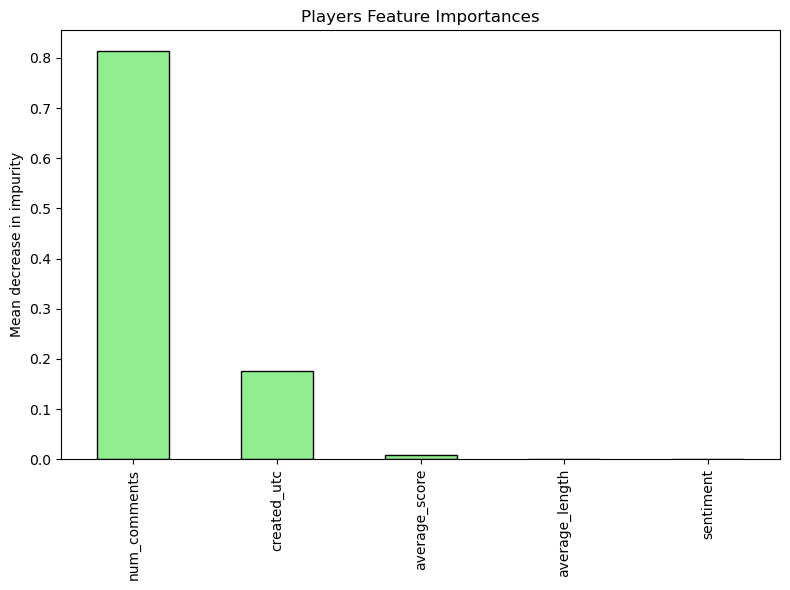

In [86]:
def MIDI_graph(model, feature_names, yname, n=None, plot=False):
    if n ==  None:
        n = len(feature_names)

    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)[0:n]

    fig, ax = plt.subplots(figsize=(8, 6))
    forest_importances.plot.bar(ax=ax, color = "lightgreen", ec="black")
    ax.set_title("{} Feature Importances".format(yname))
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

MIDI_graph(forrest_model, xcols, ycol)